In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adeniranstephen/obesity-prediction-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/obesity-prediction-dataset


📊 Dataset loaded: 2111 rows × 17 columns

📋 Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   int64  
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 no

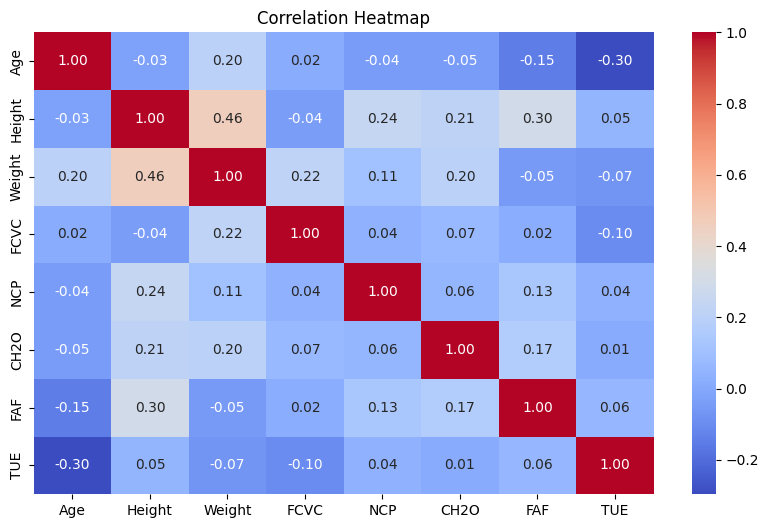

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ====== 1. Load Data ======
df = pd.read_csv("/kaggle/input/obesity-prediction-dataset/ObesityDataSet_raw_and_data_sinthetic.csv")  # Ganti dengan nama file kamu
print(f"📊 Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")

# ====== 2. Basic Info ======
print("\n📋 Basic Info:")
print(df.info())

# ====== 3. Missing Values Check ======
print("\n🔍 Missing Values:")
missing = df.isnull().sum()
print(missing[missing > 0])

# ====== 4. Skewness Check ======
print("\n📈 Skewness Check:")
skewed_features = df.select_dtypes(include=['number']).apply(lambda x: x.skew()).sort_values(ascending=False)
print(skewed_features)

print("\n📌 Recommendation:")
for col, skew in skewed_features.items():
    if abs(skew) > 1:
        print(f"⚠️ {col} is highly skewed (skew={skew:.2f}). Suggest: Apply log or sqrt transform.")
    elif abs(skew) > 0.5:
        print(f"ℹ️ {col} is moderately skewed (skew={skew:.2f}). Transform optional.")
    else:
        print(f"✅ {col} is fairly symmetric (skew={skew:.2f}). No action needed.")

# ====== 5. Outlier Detection (IQR Method) ======
print("\n📦 Outlier Check (IQR Method):")
for col in df.select_dtypes(include=['number']):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outlier_count = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
    if outlier_count > 0:
        print(f"⚠️ {col}: {outlier_count} outliers detected.")
    else:
        print(f"✅ {col}: No significant outliers.")

# ====== 6. Correlation Analysis ======
print("\n🔗 Correlation Matrix (Top correlated pairs):")
correlation = df.corr(numeric_only=True)
cor_matrix = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()
top_corr = cor_matrix[(cor_matrix < 1) & (cor_matrix > 0.7)]
print(top_corr)

print("\n📌 Recommendation:")
for (f1, f2), corr_val in top_corr.items():
    print(f"⚠️ {f1} & {f2} have high correlation ({corr_val:.2f}). Suggest: Keep only one or apply dimensionality reduction (e.g., PCA).")

# ====== 7. Heatmap ======
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [4]:
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [5]:
# Transformasi log
df["Age"] = np.log1p(df["Age"])
df["NCP"] = np.log1p(df["NCP"])

In [6]:
# Encoding data kategorikal

# data non-ordinal
df = pd.get_dummies(df, columns=["Gender", "family_history_with_overweight","FAVC","CAEC","SMOKE","SCC","CALC","MTRANS"], drop_first=True)

# data ordinal
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["NObeyesdad"] = le.fit_transform(df["NObeyesdad"])

In [7]:
# Pisahkan Fitur dan Target
X = df.drop("NObeyesdad", axis=1)
y = df["NObeyesdad"]

In [9]:
# training model
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # stratify untuk data klasifikasi
)

In [11]:
# Training model
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

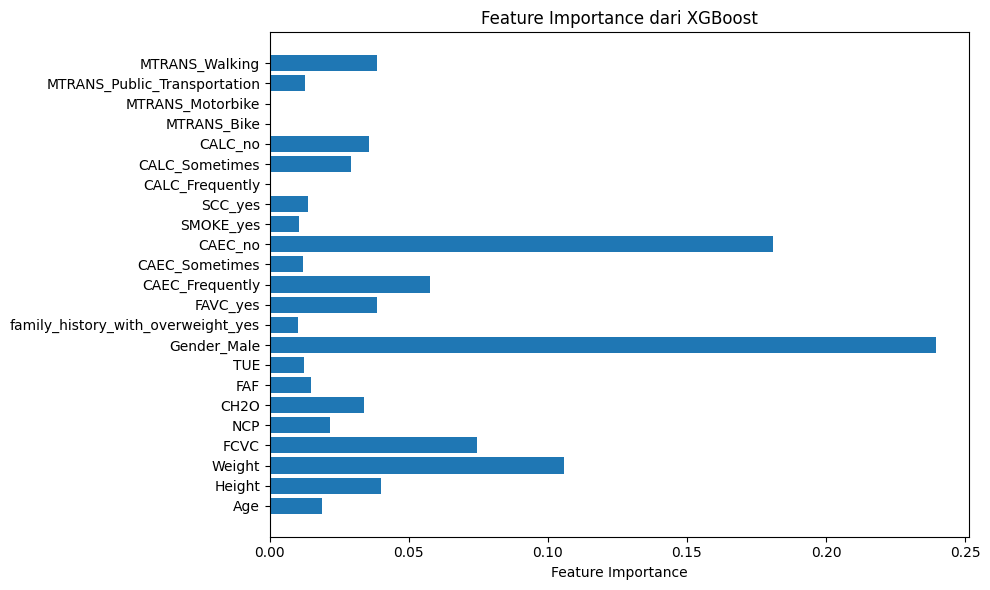

In [15]:
# Ambil feature importance
importances = model.feature_importances_
feature_names = X.columns

# Tampilkan secara visual
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("Feature Importance dari XGBoost")
plt.tight_layout()
plt.show()

In [16]:
# Prediksi & Evaluasi
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94        54
           1       0.85      0.97      0.90        58
           2       0.96      0.99      0.97        70
           3       0.98      0.98      0.98        60
           4       1.00      0.98      0.99        65
           5       0.98      0.91      0.95        58
           6       0.98      0.97      0.97        58

    accuracy                           0.96       423
   macro avg       0.96      0.96      0.96       423
weighted avg       0.96      0.96      0.96       423

